# 图像增广



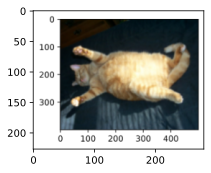

In [16]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [2]:
'''
img：输入的单张图像（PIL或Tensor格式）
aug：数据增强操作（如旋转、翻转、颜色变换等）
num_rows：展示网格的行数（默认2行）
num_cols：展示网格的列数（默认4列）
scale：图像显示放大倍数（默认1.5倍）
'''
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    # 列表推导式：对同一张图像应用num_rows*num_cols次增强
    # 生成8张（2×4）不同的增强图像
    # _：循环变量占位符（表示不关心第几次循环）
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale) # 2行4列，放大1.5倍显示

左右翻转图像

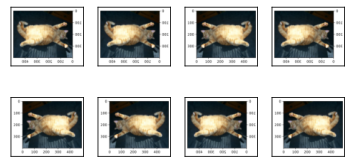

In [3]:
'''
img: 输入的单张图像
aug = torchvision.transforms.RandomHorizontalFlip(): 随机水平翻转操作
增强操作 RandomHorizontalFlip()：
功能：以50%概率随机水平翻转图像（左→右镜像）
随机性：每次调用aug(img)都是独立随机的，可能翻也可能不翻
'''
apply(img, torchvision.transforms.RandomHorizontalFlip())

上下翻转图像

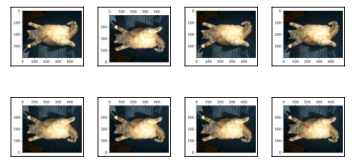

In [4]:
apply(img, torchvision.transforms.RandomVerticalFlip())

随机裁剪

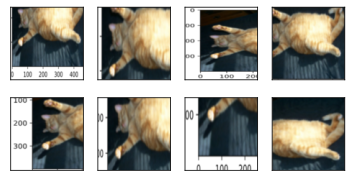

In [5]:
'''
scale小：模拟远距离目标（目标在图中占比小）
scale大：模拟近距离目标（目标充满画面）
ratio变化：模拟相机拍摄角度倾斜
随机位置：模拟目标在画面中任意位置
步骤1：随机选择裁剪区域
面积：在[原图10%, 原图100%] 范围内随机选
长宽比：在[0.5,2]范围内随机选
位置：在原图中随机坐标裁剪
步骤2：强制缩放
将裁剪得到的区域不管原始大小，一律拉伸/压缩到200×200
'''
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), # 最终输出尺寸：强制缩放为200×200像素
    scale=(0.1, 1), # 裁剪区域面积比例：原图的10%到100%
    ratio=(0.5, 2)) # 裁剪区域长宽比：0.5（宽扁）到 2（高瘦）
apply(img, shape_aug)

随机更改图像的亮度

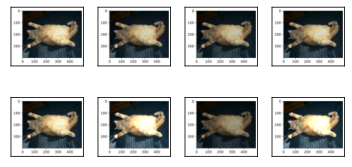

In [6]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, # 亮度调整范围：原图的[1-0.5,1+0.5]=[0.5,1.5]倍
    contrast=0, # 对比度：不调整（范围[1,1]）
    saturation=0, # 饱和度：不调整
    hue=0 # 色调：不调整
))

随机更改图像的色调

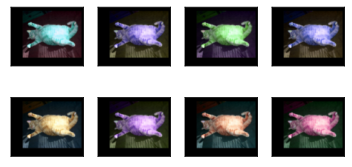

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

随机更改图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）

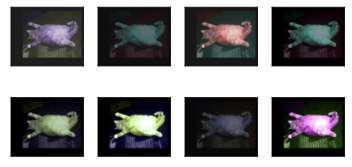

In [8]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

结合多种图像增广方法

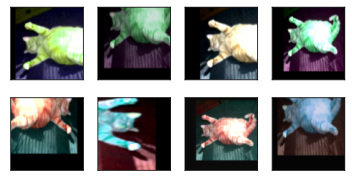

In [9]:
'''
每次aug(img)的执行链：
img → RandomHorizontalFlip() → 翻转结果 → color_aug(调亮度) → 颜色结果 → shape_aug(裁剪缩放) → 最终输出
当你调用 transform(img) 时，等价于：
img → A(img) → B(A的输出) → C(B的输出) → 最终结果
'''
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), # 第1步：抛硬币决定是否左右镜像
    color_aug, # 第2步：随机调整亮度
    shape_aug]) # 第3步：随机裁剪+缩放
apply(img, augs)

使用图像增广进行训练

100%|██████████| 170498071/170498071 [01:23<00:00, 2029831.62it/s]


Extracting ../data\cifar-10-python.tar.gz to ../data


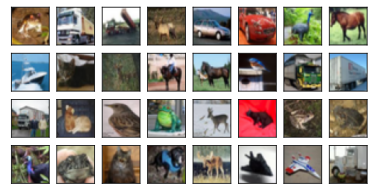

In [10]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=False)
'''
第一个参数：32张图像的列表
第二个参数4: 行数
第三个参数8: 列数
scale=0.8: 图像显示缩放比例（0.8倍）
'''
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

只使用最简单的随机左右翻转

In [11]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(), # p=0.5概率左右镜像
     torchvision.transforms.ToTensor()]) # PIL → Tensor，像素归一化[0,255]→[0,1]

test_augs = torchvision.transforms.Compose([ 
     torchvision.transforms.ToTensor()]) # 不做任何增强，保持原始图像

定义一个辅助函数，以便于读取图像和应用图像增广

In [12]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=False)
    dataloader = torch.utils.data.DataLoader(
        dataset, # 1. 数据集对象（如CIFAR-10）
        batch_size=batch_size, # 2. 每批加载的样本数（如64）
        shuffle=is_train, # 3. 是否打乱数据（训练时True，测试时False）
        # 作用：用多少个CPU进程并行加载数据
        # d2l.get_dataloader_workers() 通常返回 CPU核心数
        num_workers=d2l.get_dataloader_workers()) # 4. 并行加载进程数
    return dataloader

| 代码行                   | 函数/方法                               | 来源          | 作用         |
| --------------------- | ----------------------------------- | ----------- | ---------- |
| `net.train()`         | `nn.Module.train()`                 | **PyTorch** | 设置模型为训练模式  |
| `trainer.zero_grad()` | `torch.optim.Optimizer.zero_grad()` | **PyTorch** | 清空优化器梯度    |
| `pred = net(X)`       | `nn.Module.__call__()`              | **PyTorch** | 前向传播       |
| `l = loss(pred, y)`   | `nn.Module.__call__()`              | **PyTorch** | 计算损失值      |
| `l.sum().backward()`  | `torch.Tensor.backward()`           | **PyTorch** | 反向传播（计算梯度） |
| `trainer.step()`      | `torch.optim.Optimizer.step()`      | **PyTorch** | 更新模型参数     |
| `d2l.accuracy(...)`   | `d2l.accuracy()`                    | **d2l库**    | 计算预测准确率    |


定义一个函数，使用多GPU对模型进行训练和评估

In [13]:
'''
数据X,y → GPU → net.train() → zero_grad()
    ↓
前向传播 → pred → loss → l
    ↓
反向传播 ← backward() ← l.sum()
    ↓
参数更新 ← trainer.step()
    ↓
返回：损失和，正确数
net: 神经网络模型
X: 输入数据（可能是列表或张量）
y: 真实标签
loss: 损失函数
trainer: 优化器（如SGD、Adam）
devices: GPU设备列表（如['cuda:0', 'cuda:1']）
'''
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X] # 如果X是列表，将每个元素都移到GPU
    else:
        X = X.to(devices[0]) # 否则直接移动整个张量
    y = y.to(devices[0]) # 标签也移到GPU
    net.train() # 开启训练模式（启用Dropout/BN的更新）
    trainer.zero_grad() # 清空上一步的梯度（防止累积）
    pred = net(X) # 模型预测输出，前向传播
    l = loss(pred, y) # 计算预测值与真实值的损失
    l.sum().backward() # 梯度回传（sum()处理多GPU情况）
    trainer.step() # 优化器更新模型权重
    train_loss_sum = l.sum() # 累加本批次总损失
    train_acc_sum = d2l.accuracy(pred, y) # 计算本批次准确率
    return train_loss_sum, train_acc_sum # 返回本批次的总损失和总正确预测数（用于后续求平均）

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    # d2l.Timer()：计时器，记录每个batch的训练耗时
    # len(train_iter)：训练集总批次数（如500批/epoch）
    timer, num_batches = d2l.Timer(), len(train_iter)
    '''
    d2l.Animator：实时绘制训练曲线（类似TensorBoard）
    ylim=[0,1] ：纵轴范围（准确率0-100%，损失0-1）
    legend：三条曲线：训练损失、训练准确率、测试准确率
    '''
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    '''
    nn.DataParallel：自动将模型复制到所有GPU，实现数据并行
    输入数据会被均分到各GPU，各GPU独立前向/反向传播，主GPU（devices[0]）汇总梯度并更新参数
    .to(devices[0])：模型参数放在主GPU上
    '''
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4) # 4个指标：损失和、准确数和、样本数
        for i, (features, labels) in enumerate(train_iter):
            timer.start() # timer.start()/stop()：精确测量该batch的训练耗时
            l, acc = train_batch_ch13( # train_batch_ch13()：训练一个batch，返回损失和、正确预测数
                net, features, labels, loss, trainer, devices)
            '''
            metric.add()：累加四个关键指标
            metric[0]	l	损失总和
            metric[1]	acc	正确预测总数
            metric[2]	labels.shape[0]	样本数（batch_size）
            metric[3]	labels.numel()	总标签数（=样本数）
            '''
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            '''
            触发条件：每完成总批次的20% 或最后一个batch
            x轴坐标：epoch + (i+1)/num_batches（小数epoch，如0.2, 0.4, 0.6...）
            y轴值：metric[0] / metric[2]：平均损失（总损失 / 总样本数）
            metric[1] / metric[3]：训练准确率（正确数 / 总标签数）
            None：测试准确率暂时不画（等epoch结束）
            '''
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        # 每个epoch结束后：在测试集上评估准确率
        # x轴坐标：整数epoch（如1, 2, 3...），y轴值：None, None, test_acc（只画测试准确率曲线）
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 最终epoch的平均损失和训练准确率，测试准确率（最后一个epoch）
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    # 性能统计：每秒处理的样本数（吞吐量），metric[2] * num_epochs：总处理样本数，timer.sum()：总耗时（秒）
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

定义`train_with_data_aug`函数，使用图像增广来训练模型

In [14]:
'''
1. 加载CIFAR-10训练集(50000张) + 应用train_augs
2. 加载CIFAR-10测试集(10000张) + 应用test_augs  
3. 创建交叉熵损失 + Adam优化器
4. 训练10个epoch，每epoch约195个batch
5. 输出实时曲线 + 最终准确率
batch_size=256：每批训练256张图像
d2l.try_all_gpus()：自动检测并使用所有可用GPU
d2l.resnet18(10, 3)：创建ResNet-18模型，10分类，3通道输入
'''
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
# 对所有全连接层/卷积层做Xavier初始化
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size) # 训练集+增强
    test_iter = load_cifar10(False, test_augs, batch_size) # 测试集无增强
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

训练模型

loss 0.162, train acc 0.943, test acc 0.840
1795.9 examples/sec on [device(type='cuda', index=0)]


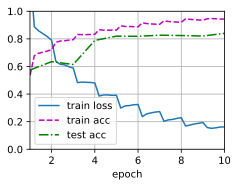

In [15]:
train_with_data_aug(train_augs, test_augs, net)